<a href="https://colab.research.google.com/github/lazarzivanovicc/ddpm/blob/main/DDPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Utils section

In [ ]:
import torch
import torch.nn as nn
from torchvision.utils import save_image, make_grid
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

import os

###ResidualConvolutionalBlock

In [ ]:
class ResidualConvolutionalBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()

        # Check if input and output channels are the same for the residual connection
        self.same_channels = in_channels == out_channels

        # Flag for whether or not to use residual connection
        self.is_res = is_res

        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # If using residual connection
        if self.is_res:
            # Apply first convolutional layer
            output_convolution_1 = self.conv1(x)

            # Apply second convolutional layer
            output_convolution_2 = self.conv2(output_convolution_1)

            # If input and output channels are the same, add residual connection directly
            if self.same_channels:
                out = x + output_convolution_2
            else:
                # If not, apply a 1x1 convolutional layer to match dimensions before adding residual connection
                shortcut = nn.Conv2d(x.shape[1], output_convolution_2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + output_convolution_2

            return out / 1.414 # Normalize output tensor/ division by sqrt(2) is a common trick wehn dealing with residual connection

        # If not using residual connection, return output of second convolutional layer
        else:
            output_convolution_1 = self.conv1(x)
            output_convolution_2 = self.conv2(output_convolution_1)
            return output_convolution_2

    # Method to get the number of output channels for this block
    def get_out_channels(self):
        return self.conv2[0].out_channels

    # Method to set the number of output channels for this block
    def set_out_channels(self, out_channels):
        self.conv1[0].out_channels = out_channels
        self.conv2[0].in_channels = out_channels
        self.conv2[0].out_channels = out_channels

###Downsampling block

In [ ]:
class UnetDownSamplingBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UnetDownSamplingBlock, self).__init__()

    # One downsampling block: ResidualConvolutionalBlock layer -> ResidualConvolutionalBlock layer -> MaxPool2d (for dimensionality reduction)
    self.model = nn.Sequential(
        ResidualConvolutionalBlock(in_channels, out_channels),
        ResidualConvolutionalBlock(out_channels, out_channels),
        nn.MaxPool2d(2, 2),
    )

  # Forward pass
  def forward(self, x) -> torch.Tensor:
    return self.model(x)


### Upsampling block

In [ ]:
class UnetUpSamplingBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UnetUpSamplingBlock, self).__init__()

    # One upsampling block: ConvTranspose2d layer -> ResidualConvolutionalBlock layer -> ResidualConvolutionalBlock layer
    self.model = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2), # Transposed convlution or deconvlution layer, used for up-sampling, doubles the spatial dimensions
        ResidualConvolutionalBlock(out_channels, out_channels),
        ResidualConvolutionalBlock(out_channels, out_channels),
    )

  def forward(self, x, skip) -> torch.Tensor:
      # Concatenate the input tensor x with the skip connection tensor along the channel dimension.
      # Skip connections help to transfer information from earlier layers of the network directly to later layers.
      # This can be especially useful in very deep networks. Common in U Net architecture.
      x = torch.cat((x, skip), 1)

      x = self.model(x)
      return x

###Embedding block

In [ ]:
# This class will enable embedding time step and context which will be very important later
class EmbeddingBlock(nn.Module):
  def __init__(self, input_dim, embedding_dim):
    super(EmbeddingBlock, self).__init__()

    self.input_dim = input_dim

    self.model = nn.Sequential(
        nn.Linear(input_dim, embedding_dim),
        nn.GELU(),
        nn.Linear(embedding_dim, embedding_dim),
    )

  def forward(self, x):
      # flatten the input tensor
      x = x.view(-1, self.input_dim)
      # apply the model layers to the flattened tensor
      return self.model(x)

###Plot sample

In [ ]:
def normalize_to_unit_range(image):
    """
    Normalize the pixel values of an image to the range [0, 1].
    Assumes the input image is in the format (height, width, channels).
    """
    # Calculate the maximum and minimum values across the height and width dimensions for each channel
    max_vals = image.max(axis=(0, 1))
    min_vals = image.min(axis=(0, 1))

    # Perform normalization
    normalized_image = (image - min_vals) / (max_vals - min_vals)
    return normalized_image

def normalize_all_timesteps(data, num_timesteps, num_samples):
    """
    Apply normalization to the range [0, 1] for all timesteps of all samples in the data.

    Parameters:
    data (numpy.ndarray): The input data to be normalized.
    num_timesteps (int): The number of timesteps.
    num_samples (int): The number of samples.

    Returns:
    numpy.ndarray: The normalized data.
    """
    # Initialize an array to store the normalized data with the same shape as the input data
    normalized_data = np.zeros_like(data)

    # Loop over each timestep and each sample
    for t in range(num_timesteps):
        for s in range(num_samples):
            # Normalize the data for the current timestep and sample
            normalized_data[t, s] = normalize_to_unit_range(data[t, s])

    return normalized_data

def plot_generated_samples(sample_store, num_samples, num_rows, save_directory, filename, width, save_animation=False):
    """
    Plot and optionally save a GIF of generated samples evolving over time.

    Parameters:
    sample_store (numpy.ndarray): The generated samples to be plotted.
    num_samples (int): The number of samples to be plotted.
    num_rows (int): The number of rows in the plot grid.
    save_directory (str): Directory to save the animation.
    filename (str): Filename for the saved animation.
    width (int): Width parameter for the saved animation.
    save_animation (bool): Whether to save the animation as a GIF.

    Returns:
    FuncAnimation: The animation object.
    """
    num_cols = num_samples // num_rows
    rearranged_store = np.moveaxis(sample_store, 2, 4)  # Change to Numpy image format (h, w, channels) from (channels, h, w)
    normalized_store = normalize_all_timesteps(rearranged_store, rearranged_store.shape[0], num_samples)  # Normalize to range [0, 1] for np.imshow

    # Create GIF of images evolving over time based on sample_store
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, sharey=True, figsize=(num_cols, num_rows))

    def animate_frame(frame_idx, store):
        print(f'Animating frame {frame_idx} of {store.shape[0]}', end='\r')
        plots = []
        for row in range(num_rows):
            for col in range(num_cols):
                axs[row, col].clear()
                axs[row, col].set_xticks([])
                axs[row, col].set_yticks([])
                plots.append(axs[row, col].imshow(store[frame_idx, (row * num_cols) + col]))
        return plots

    animation = FuncAnimation(fig, animate_frame, fargs=[normalized_store], interval=200, blit=False, repeat=True, frames=normalized_store.shape[0])
    plt.close()

    if save_animation:
        animation.save(f"{save_directory}/{filename}_w{width}.gif", dpi=100, writer=PillowWriter(fps=5))
        print(f'Saved GIF at {save_directory}/{filename}_w{width}.gif')

    return animation

###Custom dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, sfilename, lfilename, transform, null_context=False):
        self.sprites = np.load(sfilename)
        self.slabels = np.load(lfilename)
        print(f"sprite shape: {self.sprites.shape}")
        print(f"labels shape: {self.slabels.shape}")
        self.transform = transform
        self.null_context = null_context
        self.sprites_shape = self.sprites.shape
        self.slabel_shape = self.slabels.shape

    # Return the number of images in the dataset
    def __len__(self):
        return len(self.sprites)

    # Get the image and label at a given index
    def __getitem__(self, idx):
        # Return the image and label as a tuple
        if self.transform:
            image = self.transform(self.sprites[idx])
            if self.null_context:
                label = torch.tensor(0).to(torch.int64)
            else:
                label = torch.tensor(self.slabels[idx]).to(torch.int64)
        return (image, label)

    def getshapes(self):
        # return shapes of data and labels
        return self.sprites_shape, self.slabel_shape

transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    transforms.Normalize((0.5,), (0.5,))  # range [-1,1]

])

#Main

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid

from typing import Dict, Tuple

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

import numpy as np

from IPython.display import HTML

#UNet

In [ ]:
class Unet(nn.Module):
  def __init__(self, in_channels, n_feat = 256, n_cfeat = 10, height = 28): # n_feat = 16x16, cfeat - context features
    super(Unet, self).__init__()

    self.in_channels = in_channels
    self.n_feat = n_feat
    self.n_cfeat = n_cfeat
    self.h = height # assume h == w must be divisible by 4

    # Init the initial conv layer
    self.init_conv = ResidualConvolutionalBlock(in_channels, n_feat, is_res = True)

    self.down_sampling_block_1 = UnetDownSamplingBlock(n_feat, n_feat)
    self.down_sampling_block_2 = UnetDownSamplingBlock(n_feat, 2 * n_feat)
    self.down_sampling_block_3 = UnetDownSamplingBlock(2 * n_feat, 4 * n_feat)

    self.to_vec = nn.Sequential(nn.AvgPool2d((2)), nn.GELU())

    # Embedding the timestep and context

    self.time_embedding_1 = EmbeddingBlock(1, 4 * n_feat)
    self.time_embedding_2 = EmbeddingBlock(1, 2 * n_feat)
    self.time_embedding_3 = EmbeddingBlock(1, n_feat)

    self.context_embedding_1 = EmbeddingBlock(n_cfeat, 4 * n_feat)
    self.context_embedding_2 = EmbeddingBlock(n_cfeat, 2 * n_feat)
    self.context_embedding_3 = EmbeddingBlock(n_cfeat, n_feat)

    # Upsamling part
    self.init_up = nn.Sequential(
          nn.ConvTranspose2d(4 * n_feat, 4 * n_feat, self.h//8, self.h//8),
          nn.GroupNorm(8, 4 * n_feat),
          nn.GELU(),
    )

    self.up_sampling_block_1 = UnetUpSamplingBlock(8 * n_feat, 2 * n_feat)
    self.up_sampling_block_2 = UnetUpSamplingBlock(4 * n_feat, n_feat)
    self.up_sampling_block_3 = UnetUpSamplingBlock(2 * n_feat, n_feat)

    # Initialize the final convolutional layers to map to the same number of channels as the input image
    self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, kernel_size = 3, stride = 1, padding = 1),
            nn.GroupNorm(8, n_feat),
            nn.GELU(),
            nn.Conv2d(n_feat, self.in_channels, kernel_size = 3, stride = 1, padding = 1),
    )

  def forward(self, x, time_step, context_label = None):
    """
    x : (batch, n_feat, h, w) : input image
    time_step : (batch, n_cfeat)      : time step
    context_label : (batch, n_classes)    : context label
    """
    # Initial convolution
    x = self.init_conv(x)
    # Downsampling
    down_sampling_1 = self.down_sampling_block_1(x) #[10, 256, 8, 8]
    down_sampling_2 = self.down_sampling_block_2(down_sampling_1) #[10, 256, 4, 4]
    down_sampling_3 = self.down_sampling_block_3(down_sampling_2)
    # Converting feature maps to a vector and applying an activation function
    latent_vector = self.to_vec(down_sampling_3)
    # Embedding context and timestamp
    c_embedding_1 = self.context_embedding_1(context_label).view(-1, self.n_feat * 4, 1, 1)
    t_embedding_1 = self.time_embedding_1(time_step).view(-1, self.n_feat * 4, 1, 1)
    c_embedding_2 = self.context_embedding_2(context_label).view(-1, self.n_feat * 2, 1, 1)
    t_embedding_2 = self.time_embedding_2(time_step).view(-1, self.n_feat * 2, 1, 1)
    c_embedding_3 = self.context_embedding_3(context_label).view(-1, self.n_feat, 1, 1)
    t_embedding_3 = self.time_embedding_3(time_step).view(-1, self.n_feat, 1, 1)
    # Upsampling
    up_sampling_1 = self.init_up(latent_vector)
    up_sampling_2 = self.up_sampling_block_1(c_embedding_1 * up_sampling_1 + t_embedding_1, down_sampling_3)
    up_sampling_3 = self.up_sampling_block_2(c_embedding_2 * up_sampling_2 + t_embedding_2, down_sampling_2)
    up_sampling_4 = self.up_sampling_block_3(c_embedding_3 * up_sampling_3 + t_embedding_3, down_sampling_1)

    out = self.out(torch.cat((up_sampling_4, x), 1))

    return out

###Diffusion hyperparameters

In [ ]:
timesteps = 1000
beta1 = 1e-4
beta2 = 0.02

###Network hyperparams

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64
n_cfeat = 5 # context vector is of size 5
height = 16 # 16x16 image

###Training hyperparams

In [ ]:
batch_size = 100
n_epoch = 75
lrate=1e-3

###DDPM noise schedule

In [ ]:
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()
ab_t[0] = 1

###Neural network and optimizer

In [ ]:
nn_model = Unet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

optimizer = torch.optim.Adam(nn_model.parameters(), lr=lrate)

###Connecting to Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


###Loading Data

In [ ]:
dataset = CustomDataset("/content/gdrive/My Drive/LZ/sprites.npy", "/content/gdrive/My Drive/LZ/sprites_labels.npy", transform, null_context=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


####Helper function: perturbs an image to a specified noise level

In [ ]:
def perturb_input(x, time_step, noise):
    scale_factor = ab_t.sqrt()[time_step, None, None, None]
    noise_scale = (1 - ab_t[time_step, None, None, None])
    return scale_factor * x + noise_scale * noise

###Training

####Models directory

In [ ]:
save_dir = "/content/gdrive/My Drive/models/"

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

epoch 0


Loss: 0.2487: 100%|██████████| 894/894 [00:25<00:00, 34.69it/s]


Average loss for epoch 0: 0.2351
saved model at /content/gdrive/My Drive/models/model_0.pth
epoch 1


Loss: 0.1359: 100%|██████████| 894/894 [00:23<00:00, 38.58it/s]


Average loss for epoch 1: 0.1604
epoch 2


Loss: 0.1296: 100%|██████████| 894/894 [00:23<00:00, 38.87it/s]


Average loss for epoch 2: 0.1410
epoch 3


Loss: 0.1244: 100%|██████████| 894/894 [00:22<00:00, 39.06it/s]


Average loss for epoch 3: 0.1316
epoch 4


Loss: 0.0993: 100%|██████████| 894/894 [00:23<00:00, 37.68it/s]


Average loss for epoch 4: 0.1238
saved model at /content/gdrive/My Drive/models/model_4.pth
epoch 5


Loss: 0.1134: 100%|██████████| 894/894 [00:23<00:00, 38.71it/s]


Average loss for epoch 5: 0.1181
epoch 6


Loss: 0.1048: 100%|██████████| 894/894 [00:23<00:00, 38.67it/s]


Average loss for epoch 6: 0.1139
epoch 7


Loss: 0.1020: 100%|██████████| 894/894 [00:22<00:00, 39.52it/s]


Average loss for epoch 7: 0.1093
epoch 8


Loss: 0.1127: 100%|██████████| 894/894 [00:22<00:00, 39.07it/s]


Average loss for epoch 8: 0.1056
saved model at /content/gdrive/My Drive/models/model_8.pth
epoch 9


Loss: 0.1411: 100%|██████████| 894/894 [00:22<00:00, 39.52it/s]


Average loss for epoch 9: 0.1028
epoch 10


Loss: 0.1151: 100%|██████████| 894/894 [00:23<00:00, 38.77it/s]


Average loss for epoch 10: 0.1001
epoch 11


Loss: 0.0997: 100%|██████████| 894/894 [00:23<00:00, 38.20it/s]


Average loss for epoch 11: 0.0973
epoch 12


Loss: 0.0834: 100%|██████████| 894/894 [00:22<00:00, 38.92it/s]


Average loss for epoch 12: 0.0959
saved model at /content/gdrive/My Drive/models/model_12.pth
epoch 13


Loss: 0.0811: 100%|██████████| 894/894 [00:22<00:00, 39.00it/s]


Average loss for epoch 13: 0.0941
epoch 14


Loss: 0.0847: 100%|██████████| 894/894 [00:22<00:00, 38.99it/s]


Average loss for epoch 14: 0.0915
epoch 15


Loss: 0.0892: 100%|██████████| 894/894 [00:22<00:00, 39.64it/s]


Average loss for epoch 15: 0.0893
epoch 16


Loss: 0.0828: 100%|██████████| 894/894 [00:22<00:00, 39.25it/s]


Average loss for epoch 16: 0.0880
saved model at /content/gdrive/My Drive/models/model_16.pth
epoch 17


Loss: 0.0592: 100%|██████████| 894/894 [00:22<00:00, 39.16it/s]


Average loss for epoch 17: 0.0868
epoch 18


Loss: 0.0794: 100%|██████████| 894/894 [00:22<00:00, 39.91it/s]


Average loss for epoch 18: 0.0873
epoch 19


Loss: 0.0915: 100%|██████████| 894/894 [00:22<00:00, 39.59it/s]


Average loss for epoch 19: 0.0845
epoch 20


Loss: 0.0634: 100%|██████████| 894/894 [00:22<00:00, 39.03it/s]


Average loss for epoch 20: 0.0839
saved model at /content/gdrive/My Drive/models/model_20.pth
epoch 21


Loss: 0.1019: 100%|██████████| 894/894 [00:23<00:00, 38.78it/s]


Average loss for epoch 21: 0.0823
epoch 22


Loss: 0.0852: 100%|██████████| 894/894 [00:22<00:00, 39.79it/s]


Average loss for epoch 22: 0.0814
epoch 23


Loss: 0.0693: 100%|██████████| 894/894 [00:22<00:00, 39.00it/s]


Average loss for epoch 23: 0.0814
epoch 24


Loss: 0.0864: 100%|██████████| 894/894 [00:22<00:00, 39.60it/s]


Average loss for epoch 24: 0.0803
saved model at /content/gdrive/My Drive/models/model_24.pth
epoch 25


Loss: 0.0803: 100%|██████████| 894/894 [00:22<00:00, 40.00it/s]


Average loss for epoch 25: 0.0791
epoch 26


Loss: 0.0609: 100%|██████████| 894/894 [00:22<00:00, 38.92it/s]


Average loss for epoch 26: 0.0769
epoch 27


Loss: 0.0632: 100%|██████████| 894/894 [00:22<00:00, 40.41it/s]


Average loss for epoch 27: 0.0773
epoch 28


Loss: 0.0639: 100%|██████████| 894/894 [00:22<00:00, 39.46it/s]


Average loss for epoch 28: 0.0768
saved model at /content/gdrive/My Drive/models/model_28.pth
epoch 29


Loss: 0.0823: 100%|██████████| 894/894 [00:22<00:00, 39.58it/s]


Average loss for epoch 29: 0.0760
epoch 30


Loss: 0.0906: 100%|██████████| 894/894 [00:22<00:00, 40.16it/s]


Average loss for epoch 30: 0.0767
epoch 31


Loss: 0.0724: 100%|██████████| 894/894 [00:22<00:00, 39.70it/s]


Average loss for epoch 31: 0.0749
epoch 32


Loss: 0.0544: 100%|██████████| 894/894 [00:22<00:00, 39.46it/s]


Average loss for epoch 32: 0.0750
saved model at /content/gdrive/My Drive/models/model_32.pth
epoch 33


Loss: 0.0902: 100%|██████████| 894/894 [00:22<00:00, 39.75it/s]


Average loss for epoch 33: 0.0737
epoch 34


Loss: 0.0898: 100%|██████████| 894/894 [00:23<00:00, 38.52it/s]


Average loss for epoch 34: 0.0745
epoch 35


Loss: 0.0559: 100%|██████████| 894/894 [00:22<00:00, 39.33it/s]


Average loss for epoch 35: 0.0728
epoch 36


Loss: 0.1183: 100%|██████████| 894/894 [00:23<00:00, 38.52it/s]


Average loss for epoch 36: 0.0721
saved model at /content/gdrive/My Drive/models/model_36.pth
epoch 37


Loss: 0.0657: 100%|██████████| 894/894 [00:22<00:00, 39.56it/s]


Average loss for epoch 37: 0.0715
epoch 38


Loss: 0.0791: 100%|██████████| 894/894 [00:22<00:00, 40.27it/s]


Average loss for epoch 38: 0.0721
epoch 39


Loss: 0.0881: 100%|██████████| 894/894 [00:22<00:00, 39.72it/s]


Average loss for epoch 39: 0.0702
epoch 40


Loss: 0.0632: 100%|██████████| 894/894 [00:22<00:00, 39.24it/s]


Average loss for epoch 40: 0.0703
saved model at /content/gdrive/My Drive/models/model_40.pth
epoch 41


Loss: 0.0982: 100%|██████████| 894/894 [00:23<00:00, 38.86it/s]


Average loss for epoch 41: 0.0692
epoch 42


Loss: 0.0550: 100%|██████████| 894/894 [00:22<00:00, 40.20it/s]


Average loss for epoch 42: 0.0698
epoch 43


Loss: 0.0559: 100%|██████████| 894/894 [00:22<00:00, 39.88it/s]


Average loss for epoch 43: 0.0690
epoch 44


Loss: 0.0858: 100%|██████████| 894/894 [00:22<00:00, 39.84it/s]


Average loss for epoch 44: 0.0694
saved model at /content/gdrive/My Drive/models/model_44.pth


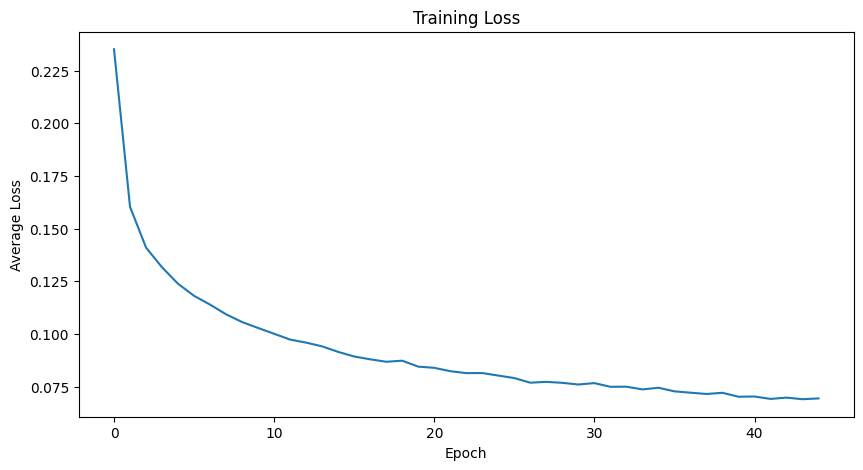

In [ ]:
nn_model.train()
losses = []

for ep in range(n_epoch):
    print(f'epoch {ep}')

    # LD learning rate
    optimizer.param_groups[0]['lr'] = lrate * (1 - ep / n_epoch)

    epoch_losses = []
    pbar = tqdm(dataloader, mininterval=2)
    for x, c in pbar:   # x: images  c: context
        optimizer.zero_grad()
        x = x.to(device)
        c = c.to(device)

        # randomly mask out c
        context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
        c = c * context_mask.unsqueeze(-1)

        # perturb data
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device)
        x_pert = perturb_input(x, t, noise)

        # use network to recover noise
        pred_noise = nn_model(x_pert, t / timesteps, context_label=c)

        # Loss is mean squared error between the PREDICTED and TRUE NOISE
        loss = F.mse_loss(pred_noise, noise)
        loss.backward()

        optimizer.step()

        # Track loss
        epoch_losses.append(loss.item())
        pbar.set_description(f"Loss: {loss.item():.4f}")

    # Calculate average loss for the epoch
    avg_loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(avg_loss)
    print(f"Average loss for epoch {ep}: {avg_loss:.4f}")

    # Save model periodically
    if ep % 4 == 0 or ep == int(n_epoch - 1):
        torch.save(nn_model.state_dict(), save_dir + f"model_{ep}.pth")
        print('saved model at ' + save_dir + f"model_{ep}.pth")

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(range(n_epoch), losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.savefig(save_dir + 'loss_plot.png')
plt.show()

###Helper function to add noise during the sampling process

In [ ]:
def apply_denoise_add_noise(input_data, timestep, predicted_noise, random_noise=None):
    if random_noise is None:
        random_noise = torch.randn_like(input_data)
    noise_factor = b_t.sqrt()[timestep] * random_noise
    adjusted_mean = (input_data - predicted_noise * ((1 - a_t[timestep]) / (1 - ab_t[timestep]).sqrt())) / a_t[timestep].sqrt()
    return adjusted_mean + noise_factor

###Evaluate model

In [ ]:
# load in model weights and set to eval mode
# nn_model_path = "gdrive/My Drive/models/model_74.pth"
# nn_model.load_state_dict(torch.load(nn_model_path))

nn_model.eval()
print("Loaded in Model")

Loaded in Model


###Sampling

In [ ]:
@torch.no_grad()
def generate_samples_ddpm(num_samples, context_label, save_frequency=20):
    # Initialize samples with noise from a normal distribution
    samples = torch.randn(num_samples, 3, height, height).to(device)

    # List to store intermediate steps
    intermediate_steps = []
    for step in range(timesteps, 0, -1):
        print(f'Generating samples at timestep {step:3d}', end='\r')

        # Adjust the time tensor
        time_tensor = torch.tensor([step / timesteps])[:, None, None, None].to(device)

        # Inject random noise unless at the final step
        random_noise = torch.randn_like(samples) if step > 1 else 0

        # Predict the noise component for the current samples
        noise_prediction = nn_model(samples, time_tensor, context_label=context_label)
        # This needs to be done in order to have stable outputs
        samples = apply_denoise_add_noise(samples, step, noise_prediction, random_noise)

        # Save intermediate samples at specific intervals
        if step % save_frequency == 0 or step == timesteps or step < 8:
            intermediate_steps.append(samples.detach().cpu().numpy())

    intermediate_steps = np.stack(intermediate_steps)
    return samples, intermediate_steps

###Helper function to display images

In [ ]:
def show_images_with_labels(imgs, labels, nrow=2):
    ncol = len(imgs) // nrow
    fig, axs = plt.subplots(nrow, ncol, figsize=(20, 12))
    axs = axs.flatten()

    for img, label, ax in zip(imgs, labels, axs):
        img = img.permute(1, 2, 0).detach().cpu().numpy()
        img = np.clip(img, 0, 1)  # Assuming the images are normalized to [0, 1]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
        ax.set_title(f"{label}")

    plt.tight_layout()
    plt.show()

###Show images from dataset with labels

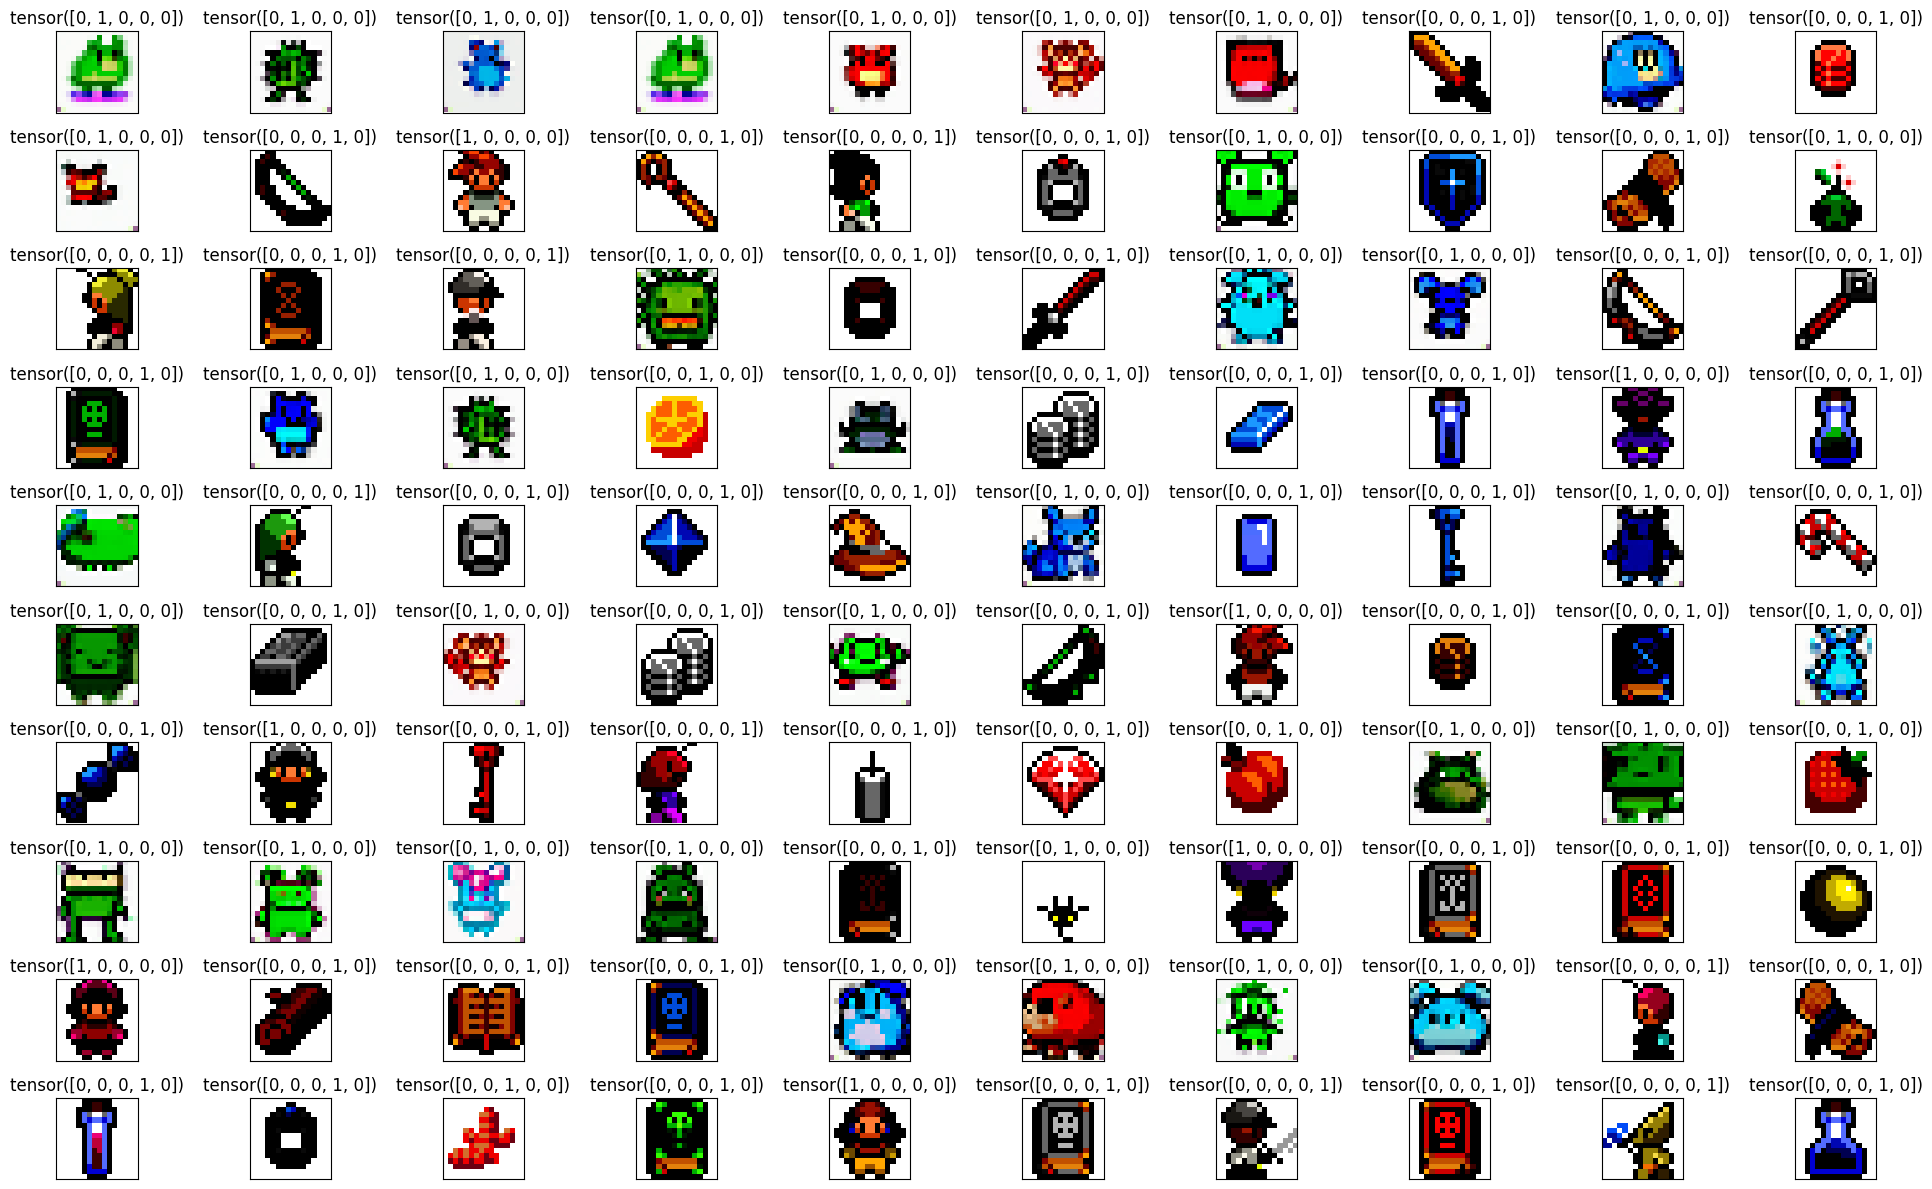

In [ ]:
# Get a batch of images from the dataloader
data_iter = iter(dataloader)
images, labels = next(data_iter)

# Plot the images with labels
show_images_with_labels(images, labels, nrow=10)

In [ ]:
# visualize samples with randomly selected context
plt.clf()
ctx = F.one_hot(torch.randint(0, 5, (32,)), 5).to(device=device).float()
samples, intermediate = generate_samples_ddpm(32, ctx)
animation_ddpm_context = plot_generated_samples(intermediate,32,4,save_dir, "ani_run", None, save_animation=False)
HTML(animation_ddpm_context.to_jshtml())

<Figure size 640x480 with 0 Axes>

In [ ]:
def show_images(imgs, nrow=2):
    _, axs = plt.subplots(nrow, imgs.shape[0] // nrow, figsize=(4,2 ))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        img = (img.permute(1, 2, 0).clip(-1, 1).detach().cpu().numpy() + 1) / 2
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
    plt.show()

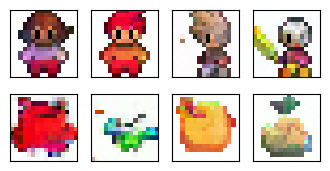

In [ ]:
# user defined context
# hero, non-hero, food, spell, side-facing
context = torch.tensor([
    [1,0,0,0,0],
    [1,0,0,0,0],
    [0,0,0,0,1],
    [0,0,0,0,1],
    [0,1,0,0,0],
    [0,1,0,0,0],
    [0,0,1,0,0],
    [0,0,1,0,0],
]).float().to(device)
samples, _ = generate_samples_ddpm(context.shape[0], context)
show_images(samples)

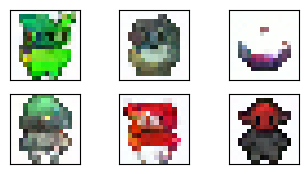

In [ ]:
# mix of defined context
# hero, non-hero, food, spell, side-facing
context = torch.tensor([
    [1,1,0,0,0],
    [1,0,0.9,0,0],
    [0,0,0.6,0.9,0],
    [1,0,0,0,1],
    [1,1,0,0,0],
    [1,0,0,1,0]
]).float().to(device)
samples, _ = generate_samples_ddpm(context.shape[0], context)
show_images(samples)